In [ ]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the dataset (replace with your actual data loading)
# Assuming the data is in a CSV file named 'landslide_data.csv'
data = pd.read_csv('Global_Landslide_Catalog_Export.csv')

from sklearn.preprocessing import LabelEncoder
import joblib

# Example: Encoding categorical columns during training
le_country = LabelEncoder()
le_admin_division = LabelEncoder()

data['country_name'] = le_country.fit_transform(data['country_name'])
data['admin_division_name'] = le_admin_division.fit_transform(data['admin_division_name'])

# Save the encoders
encoders = {
    'country_name': le_country,
    'admin_division_name': le_admin_division
}
joblib.dump(encoders, 'encoders.pkl')

# ==============================================
# Data Preprocessing
# ==============================================

# Convert date to datetime and extract temporal features
data['event_date'] = pd.to_datetime(data['event_date'])
data['month'] = data['event_date'].dt.month
data['season'] = (data['month'] % 12 + 3) // 3  # 1=winter, 2=spring, etc.

# Create binary target variable (1 if fatality occurred, 0 otherwise)
data['fatality_occurred'] = (data['fatality_count'] > 0).astype(int)

# Feature engineering
data['heavy_rain'] = data['landslide_trigger'].isin(['rain', 'downpour']).astype(int)
data['mining_area'] = (data['landslide_setting'] == 'mine').astype(int)

# ==============================================
# Feature Selection
# ==============================================

# Selected features based on our discussion
features = [
    'latitude', 'longitude',          # Geospatial
    'month', 'season',                # Temporal
    'heavy_rain',                     # Weather
    'mining_area',                    # Land use
    'landslide_size',                 # Historical patterns
    'admin_division_population'       # Human impact factor
]

target = 'fatality_occurred'  

# Prepare the data
X = data[features]
y = data[target]

# ==============================================
# Data Splitting
# ==============================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


# ==============================================
# Preprocessing Pipeline
# ==============================================

# Numeric features (standard scaling)
numeric_features = ['latitude', 'longitude', 'month', 
                   'admin_division_population']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical features (one-hot encoding)
categorical_features = ['landslide_size', 'season']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [ ]:
print(X_train.columns)  
print(X_train.head())  

Index(['latitude', 'longitude', 'month', 'season', 'heavy_rain', 'mining_area',
       'landslide_size', 'admin_division_population'],
      dtype='object')
      latitude  longitude  month  season  heavy_rain  mining_area  \
7690   40.2498   -80.6329      4       2           1            0   
893    28.2134    83.9557      8       3           1            0   
3551  -45.8243   170.5957      6       3           1            0   
3918   35.1544    74.0453      8       3           0            0   
9278   16.8256   121.0910      5       2           0            0   

     landslide_size  admin_division_population  
7690         medium                     1482.0  
893           small                   200000.0  
3551         medium                     1200.0  
3918         medium                        0.0  
9278         medium                     6819.0  


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/nikunj/Documents/Projects/Disaster/landslide_final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:25:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nikunj/Documents/Projects/Disaster/landslide_final/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [20:25:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/nikunj/Documents/Projects/Disaster/landslide_final/.venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [20:25:59] WARNING: /workspace/src/common/error_msg


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      1719
           1       0.48      0.80      0.60       488

    accuracy                           0.76      2207
   macro avg       0.71      0.78      0.72      2207
weighted avg       0.83      0.76      0.78      2207


Confusion Matrix:
[[1297  422]
 [  98  390]]

Accuracy: 0.7643860444041686


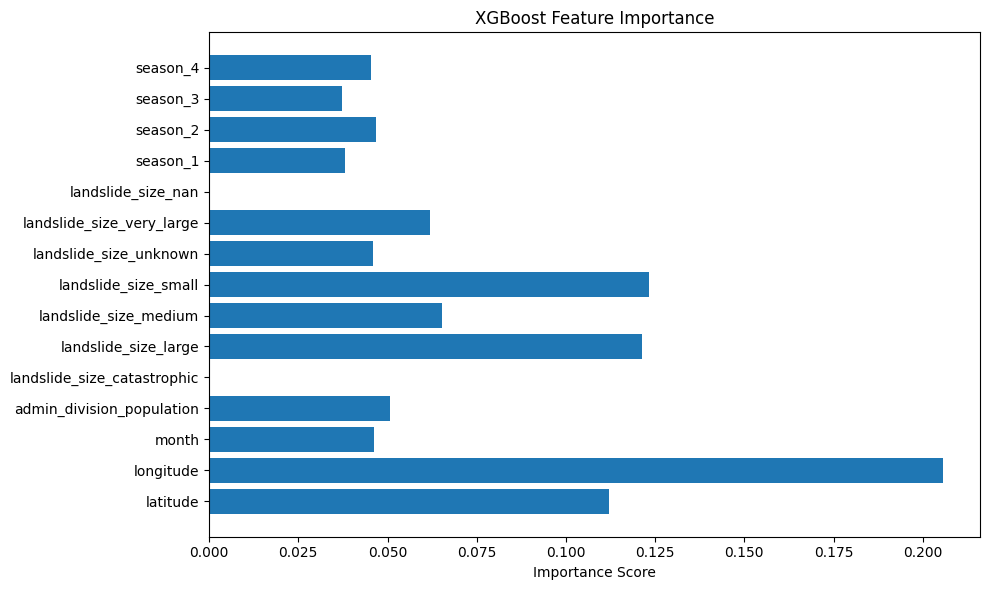

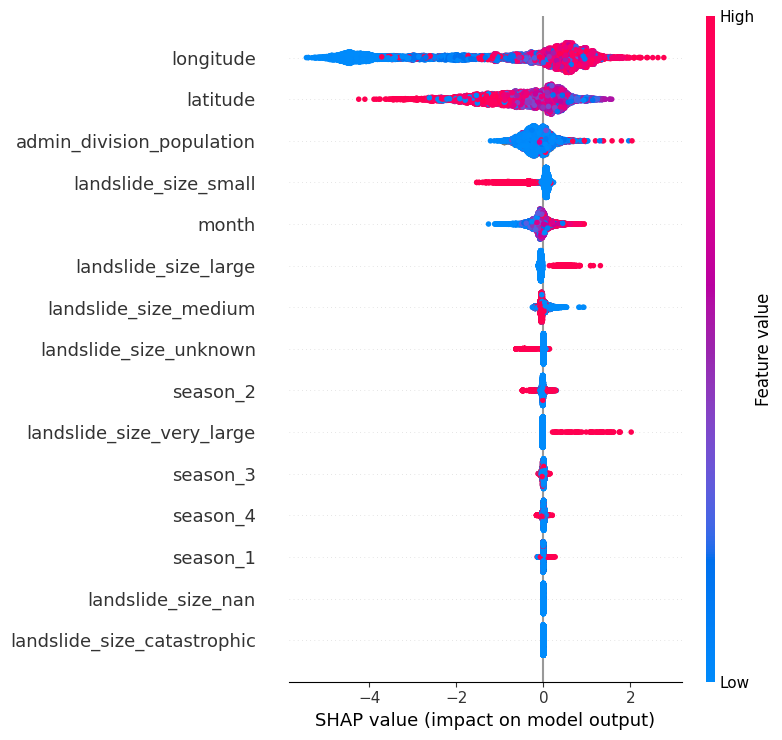


Example Prediction:
{'location': {'country': 'India', 'admin_division': 'Shimla', 'latitude': 31.1041526, 'longitude': 77.1709729, 'zip_code': 'N/A'}, 'month': 1, 'rainfall_mm': 69.6, 'prediction': 'High risk', 'probability_high_risk': 0.5406162738800049, 'probability_low_risk': 0.4593837261199951}


In [ ]:
from geopy.geocoders import Nominatim
import pandas as pd
import requests



# ==============================================
# XGBoost Model with Hyperparameter Tuning
# ==============================================

from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        objective='binary:logistic',
        enable_categorical=False ,
        tree_method='gpu_hist' 
    ))
])



param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.9],
    'classifier__colsample_bytree': [0.9],
    'classifier__gamma': [0, 0.1]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring='f1',  
    n_jobs=-1,     
    verbose=1
)



grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# ==============================================
# Model Evaluation
# ==============================================

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy:", accuracy_score(y_test, y_pred))

# ==============================================
# Feature Importance Analysis
# ==============================================

# Get feature names after preprocessing
preprocessor.fit(X)
feature_names = numeric_features + \
    list(best_model.named_steps['preprocessor']\
        .named_transformers_['cat']\
        .named_steps['onehot']\
        .get_feature_names_out(categorical_features).tolist())

# Plot feature importance
xgb_feature_importances = best_model.named_steps['classifier'].feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_names, xgb_feature_importances)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# SHAP values for model interpretation
X_processed = best_model.named_steps['preprocessor'].transform(X_train)
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_processed)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_processed, feature_names=feature_names)
# plt.title('SHAP Value Summary Plot')
# plt.tight_layout()
# plt.show()

# ==============================================
# Prediction Function for New Data
# ==============================================


def get_simple_precipitation(lat, lon, date):
    """
    Get precipitation from NOAA using lat/lon by reverse lookup to the nearest station
    """
    headers = {'token': 'OTTkgxkCdpKiEubbNzCpCcsbmisFDIFL'}
    
    # Find station near lat/lon — requires station lookup if ZIP isn't known
    # Here we'll simplify: Use a placeholder or cached locationid for now
    # Proper version needs to find closest station using NOAA metadata
    
    location_id = f"FIPS:37021"  # Replace with actual location ID if available
    
    url = f"http://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCNDMS&locationid={location_id}&startdate={date}&enddate={date}"
    
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        precip_mm = None
        for record in data.get('results', []):
            if record['datatype'] == 'TPCP':
                precip_mm = record['value'] / 10  # tenths of mm to mm
                break
                
        return precip_mm
        
    except Exception as e:
        print(f"Precipitation API Error: {e}")
        return None


def predict_landslide_risk(country, admin_division, month, date):
    """
    Predict landslide risk using real precipitation data.
    """
    # Geocoding
    geolocator = Nominatim(user_agent="landslide_pred")
    location = geolocator.geocode(f"{admin_division}, {country}")
    
    if not location:
        return {"error": "Location not found"}
    
    # Get real rainfall data
    precip_mm = get_simple_precipitation(location.latitude, location.longitude, date)
    
    if precip_mm is None:
        return {"error": "Rainfall data unavailable for the given location/date"}
    
    # Prepare input
    input_data = pd.DataFrame({
        'latitude': [location.latitude],
        'longitude': [location.longitude],
        'month': [month],
        'season': [(month % 12 + 3) // 3],
        'rainfall_mm': [precip_mm],  # New actual rainfall input
        'mining_area': [0],  # Default
        'landslide_size': ['medium'],  # Default
        'admin_division_population': [
            data[data['admin_division_name'] == admin_division]['admin_division_population'].mean() or 100000
        ]
    })
    
    # Predict
    proba = best_model.predict_proba(input_data)[0]
    prediction = best_model.predict(input_data)[0]
    
    # Extract ZIP code if available
    zipcode = location.raw.get('address', {}).get('postcode', 'N/A')

    return {
        'location': {
            'country': country,
            'admin_division': admin_division,
            'latitude': location.latitude,
            'longitude': location.longitude,
            'zip_code': zipcode
        },
        'month': month,
        'rainfall_mm': precip_mm,
        'prediction': 'High risk' if prediction == 1 else 'Low risk',
        'probability_high_risk': float(proba[1]),
        'probability_low_risk': float(proba[0])
    }



# Example usage
print("\nExample Prediction:")
print(predict_landslide_risk("India", "Shimla", 1, "2000-02-01"))  # January in Oregon

In [18]:
numeric_features = ['latitude', 'longitude', 'month', 'admin_division_population']
categorical_features = ['landslide_size', 'season']


In [19]:
from geopy.geocoders import Nominatim
import pandas as pd
import requests
import numpy as np
from math import atan2, degrees
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

class LandslidePredictor:
    def __init__(self):
        self.geolocator = Nominatim(user_agent="landslide_pred")
        self.noaa_token = "OTTkgxkCdpKiEubbNzCpCcsbmisFDIFL"
        self.elevation_service = "https://api.open-elevation.com/api/v1/lookup"
        
    def get_elevation(self, lat, lon):
        """Get elevation in meters for given coordinates"""
        params = {"locations": f"{lat},{lon}"}
        try:
            response = requests.get(self.elevation_service, params=params, timeout=5)
            return response.json()['results'][0]['elevation']
        except:
            return None
    
    def get_slope(self, lat, lon, resolution=0.01):
        """Calculate approximate slope angle in degrees"""
        directions = [(resolution, 0), (0, resolution)]  # East and North
        elevations = []
        
        for dx, dy in directions:
            elev = self.get_elevation(lat + dx, lon + dy)
            if elev:
                elevations.append(elev)
        
        if len(elevations) < 2:
            return None
            
        base_elev = self.get_elevation(lat, lon)
        horizontal_dist = 111320 * resolution  # Approx meters per degree
        slopes = [degrees(atan2((e - base_elev), horizontal_dist)) for e in elevations]
        return np.mean([s for s in slopes if s is not None])

    def get_precipitation(self, lat, lon, date):
        """Get daily precipitation in mm"""
        headers = {'token': self.noaa_token}
        
        # 1. Find nearest station
        station_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/stations"
        station_params = {
            "datasetid": "GHCND",
            "extent": f"{lat-0.5},{lon-0.5},{lat+0.5},{lon+0.5}",
            "limit": 1
        }
        
        try:
            response = requests.get(station_url, headers=headers, params=station_params, timeout=10)
            station_id = response.json()["results"][0]["id"]
            
            # 2. Get precipitation data
            data_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
            data_params = {
                "datasetid": "GHCND",
                "stationid": station_id,
                "startdate": date,
                "enddate": date,
                "datatypeid": "PRCP",
                "units": "metric"
            }
            
            response = requests.get(data_url, headers=headers, params=data_params, timeout=10)
            return response.json()["results"][0]["value"] / 10  # Convert to mm
        except:
            return None

    def prepare_features(self, country, admin_division, month, date):
        """Geocode location and fetch terrain/weather features"""
        location = self.geolocator.geocode(f"{admin_division}, {country}")
        if not location:
            return None
            
        precip = self.get_precipitation(location.latitude, location.longitude, date)
        elevation = self.get_elevation(location.latitude, location.longitude)
        slope = self.get_slope(location.latitude, location.longitude)
        
        return {
            'latitude': location.latitude,
            'longitude': location.longitude,
            'month': month,
            'season': (month % 12 + 3) // 3,
            'rainfall_mm': precip if precip else 0,
            'elevation_m': elevation if elevation else 0,
            'slope_angle': slope if slope else 0,
            'mining_area': 0,  # Default
            'landslide_size': 'medium',  # Default
            'admin_division_population': 100000  # Default
        }

# Initialize predictor
predictor = LandslidePredictor()

# ==============================================
# Model Training (Assuming X_train, y_train are prepared)
# ==============================================

# Update feature names to include new features
numeric_features = ['latitude', 'longitude', 'month', 'admin_division_population']
categorical_features = ['landslide_size', 'season']


# Update preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        objective='binary:logistic',
        enable_categorical=False,
        tree_method='gpu_hist'
    ))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.9],
    'classifier__colsample_bytree': [0.9],
    'classifier__gamma': [0, 0.1]
}

grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# ==============================================
# Enhanced Prediction Function
# ==============================================

def predict_landslide_risk(country, admin_division, month, date):
    """
    Full-featured prediction with terrain analysis
    """
    # Get all features
    features = predictor.prepare_features(country, admin_division, month, date)
    if not features:
        return {"error": "Location not found"}
    
    # Prepare input DataFrame
    input_df = pd.DataFrame([features])
    
    # Predict
    proba = best_model.predict_proba(input_df)[0]
    prediction = best_model.predict(input_df)[0]
    
    return {
        'location': {
            'country': country,
            'admin_division': admin_division,
            'coordinates': (features['latitude'], features['longitude']),
            'elevation_m': features['elevation_m'],
            'slope_angle': features['slope_angle']
        },
        'weather': {
            'month': month,
            'rainfall_mm': features['rainfall_mm'],
            'date': date
        },
        'prediction': {
            'class': 'High risk' if prediction == 1 else 'Low risk',
            'probability_high': float(proba[1]),
            'probability_low': float(proba[0])
        },
        'model_info': {
            'features_used': numeric_features + categorical_features,
            'best_params': grid_search.best_params_
        }
    }


print("\nEnhanced Prediction:")
print(predict_landslide_risk("India", "Shimla", 7, "2020-07-15"))  

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/nikunj/Documents/Projects/Disaster/landslide_final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:26:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nikunj/Documents/Projects/Disaster/landslide_final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:26:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nikunj/Documents/Projects/Disaster/landslide_final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:26:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree 


Enhanced Prediction:
{'location': {'country': 'India', 'admin_division': 'Shimla', 'coordinates': (31.1041526, 77.1709729), 'elevation_m': 2111.0, 'slope_angle': np.float64(-1.166476416338556)}, 'weather': {'month': 7, 'rainfall_mm': 4.39, 'date': '2020-07-15'}, 'prediction': {'class': 'Low risk', 'probability_high': 0.3258097171783447, 'probability_low': 0.6741902828216553}, 'model_info': {'features_used': ['latitude', 'longitude', 'month', 'admin_division_population', 'landslide_size', 'season'], 'best_params': {'classifier__colsample_bytree': 0.9, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.9}}}


In [ ]:
import joblib

# Save your pipeline model
joblib.dump(model, 'landslide_model.pkl')

# Later, to load the model:
# model = joblib.load('landslide_model.pkl')


['landslide_model.pkl']

In [21]:
print("\nExample Prediction:")
print(predict_landslide_risk("India", "Shimla", 1, "2002-07-01")) 


Example Prediction:
{'location': {'country': 'India', 'admin_division': 'Shimla', 'coordinates': (31.1041526, 77.1709729), 'elevation_m': 2111.0, 'slope_angle': np.float64(-1.166476416338556)}, 'weather': {'month': 1, 'rainfall_mm': 0, 'date': '2002-07-01'}, 'prediction': {'class': 'High risk', 'probability_high': 0.5109304189682007, 'probability_low': 0.4890695810317993}, 'model_info': {'features_used': ['latitude', 'longitude', 'month', 'admin_division_population', 'landslide_size', 'season'], 'best_params': {'classifier__colsample_bytree': 0.9, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.9}}}


In [22]:
import requests
url = "http://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCNDMS&locationid=ZIP:97001&startdate=2000-01-31&enddate=2000-02-02"
# replace 'myToken' with the actual token, below
headers = {'token': 'OTTkgxkCdpKiEubbNzCpCcsbmisFDIFL'}
response = requests.get(url, headers = headers)
response = response.json()
print(response)

{'metadata': {'resultset': {'offset': 1, 'count': 18, 'limit': 25}}, 'results': [{'date': '2000-02-01T00:00:00', 'datatype': 'CLDD', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 0}, {'date': '2000-02-01T00:00:00', 'datatype': 'DP01', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 10}, {'date': '2000-02-01T00:00:00', 'datatype': 'DP05', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 0}, {'date': '2000-02-01T00:00:00', 'datatype': 'DP10', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 0}, {'date': '2000-02-01T00:00:00', 'datatype': 'DT00', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 0}, {'date': '2000-02-01T00:00:00', 'datatype': 'DT32', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 26}, {'date': '2000-02-01T00:00:00', 'datatype': 'DT90', 'station': 'GHCND:USC00350197', 'attributes': '0,0', 'value': 0}, {'date': '2000-02-01T00:00:00', 'datatype': 'DX32', 'station': 'GHCND:USC00350197', 'attrib

In [23]:
test_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/datasets"
test = requests.get(test_url, headers=headers)
print(test.status_code)  

200


In [24]:
import requests

def get_elevation_profile(lat, lon):
    url = f"https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data['results'][0]['elevation']
    else:
        print("Request failed:", response.status_code)
        return None

# Example usage
print("\nElevation Profile:")
print(get_elevation_profile(19.054999, 72.8692035))  # Output will be elevation in meters



Elevation Profile:
2.0


In [35]:
encoders = joblib.load('encoders.pkl')
print("Categories for 'country_name':", encoders['country_name'].classes_)
print("Categories for 'admin_division_name':", encoders['admin_division_name'].classes_)

Categories for 'country_name': ['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Angola' 'Argentina'
 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bangladesh' 'Barbados'
 'Belize' 'Bermuda' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil'
 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon'
 'Canada' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba'
 'Czech Republic' 'Czechia' 'Democratic Republic of the Congo' 'Dominica'
 'Dominican Republic' 'East Timor' 'Ecuador' 'Egypt' 'El Salvador'
 'Ethiopia' 'Fiji' 'France' 'Gabon' 'Georgia' 'Germany' 'Ghana' 'Greece'
 'Grenada' 'Guam' 'Guatemala' 'Guinea' 'Haiti' 'Honduras' 'Hong Kong'
 'Iceland' 'India' 'Indonesia' 'Iran' 'Ireland' 'Isle of Man' 'Israel'
 'Italy' 'Ivory Coast' 'Jamaica' 'Japan' 'Jersey' 'Jordan' 'Kazakhstan'
 'Kenya' 'Kyrgyzstan' 'Laos' 'Lebanon' 'Liberia' 'Luxembourg' 'Macedonia'
 'Madagascar' 'Malawi' 'Malaysia' 'Mauritius' 'Mexico' 'Mongolia'
 'Montenegro' 'Morocco' 'Myanmar [Burma]' 'Namibia'

In [23]:
print(model.named_steps)

{'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['latitude', 'longitude', 'month',
                                  'admin_division_population']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['landslide_size', 'season'])]), 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
        